In [1]:
from jesse import helpers, research

from custom_indicators.all_features import feature_matrix
from research_tools import TrailingStopLabel

warmup_1m, trading_1m = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2021-01-01"),
    helpers.date_to_timestamp("2024-12-31"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

In [2]:
trailing_stop_label = TrailingStopLabel(trading_1m, n_bar=15, k=1)
features = feature_matrix(trading_1m, sequential=True)

In [3]:
from copy import deepcopy

import numpy as np
import pandas as pd

SKIP_N = 240
TRAIN_TEST_SPLIT_INDEX = int((len(trailing_stop_label.labels) - SKIP_N) * 0.7)

x_train = pd.DataFrame(
    features.features[SKIP_N:TRAIN_TEST_SPLIT_INDEX], columns=features.names
)
y_train = trailing_stop_label.labels[SKIP_N:TRAIN_TEST_SPLIT_INDEX]

mask = deepcopy(y_train)
mask = mask != 0
y_train = y_train[mask]
y_train = pd.Series((y_train == 1).astype(np.int8), name="label")
x_train = x_train[mask]
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

x_test = pd.DataFrame(
    features.features[TRAIN_TEST_SPLIT_INDEX + SKIP_N :], columns=features.names
)
y_test = trailing_stop_label.labels[TRAIN_TEST_SPLIT_INDEX + SKIP_N :]

mask = deepcopy(y_test)
mask = mask != 0
y_test = y_test[mask]
y_test = pd.Series((y_test == 1).astype(np.int8), name="label")
x_test = x_test[mask]
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1334848, 426)
(1334848,)
(604082, 426)
(604082,)


Imported lazytransform v1.18. 

Imported featurewiz 0.5.83. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True,
        		category_encoders="auto", auto_encoders='VAE', ae_options={},
        		add_missing=False, imbalanced=False, verbose=0)
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    
featurewiz is given 1.0 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['label', 'label']
    final list of scalers given: []
Loaded input data. Shape = (1334848, 426)
    selecting 426 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Binary_Classification problem 
Shape of dataset: (1334848, 426). Now we classify variables into different types...
    Returning dictionary for variable t

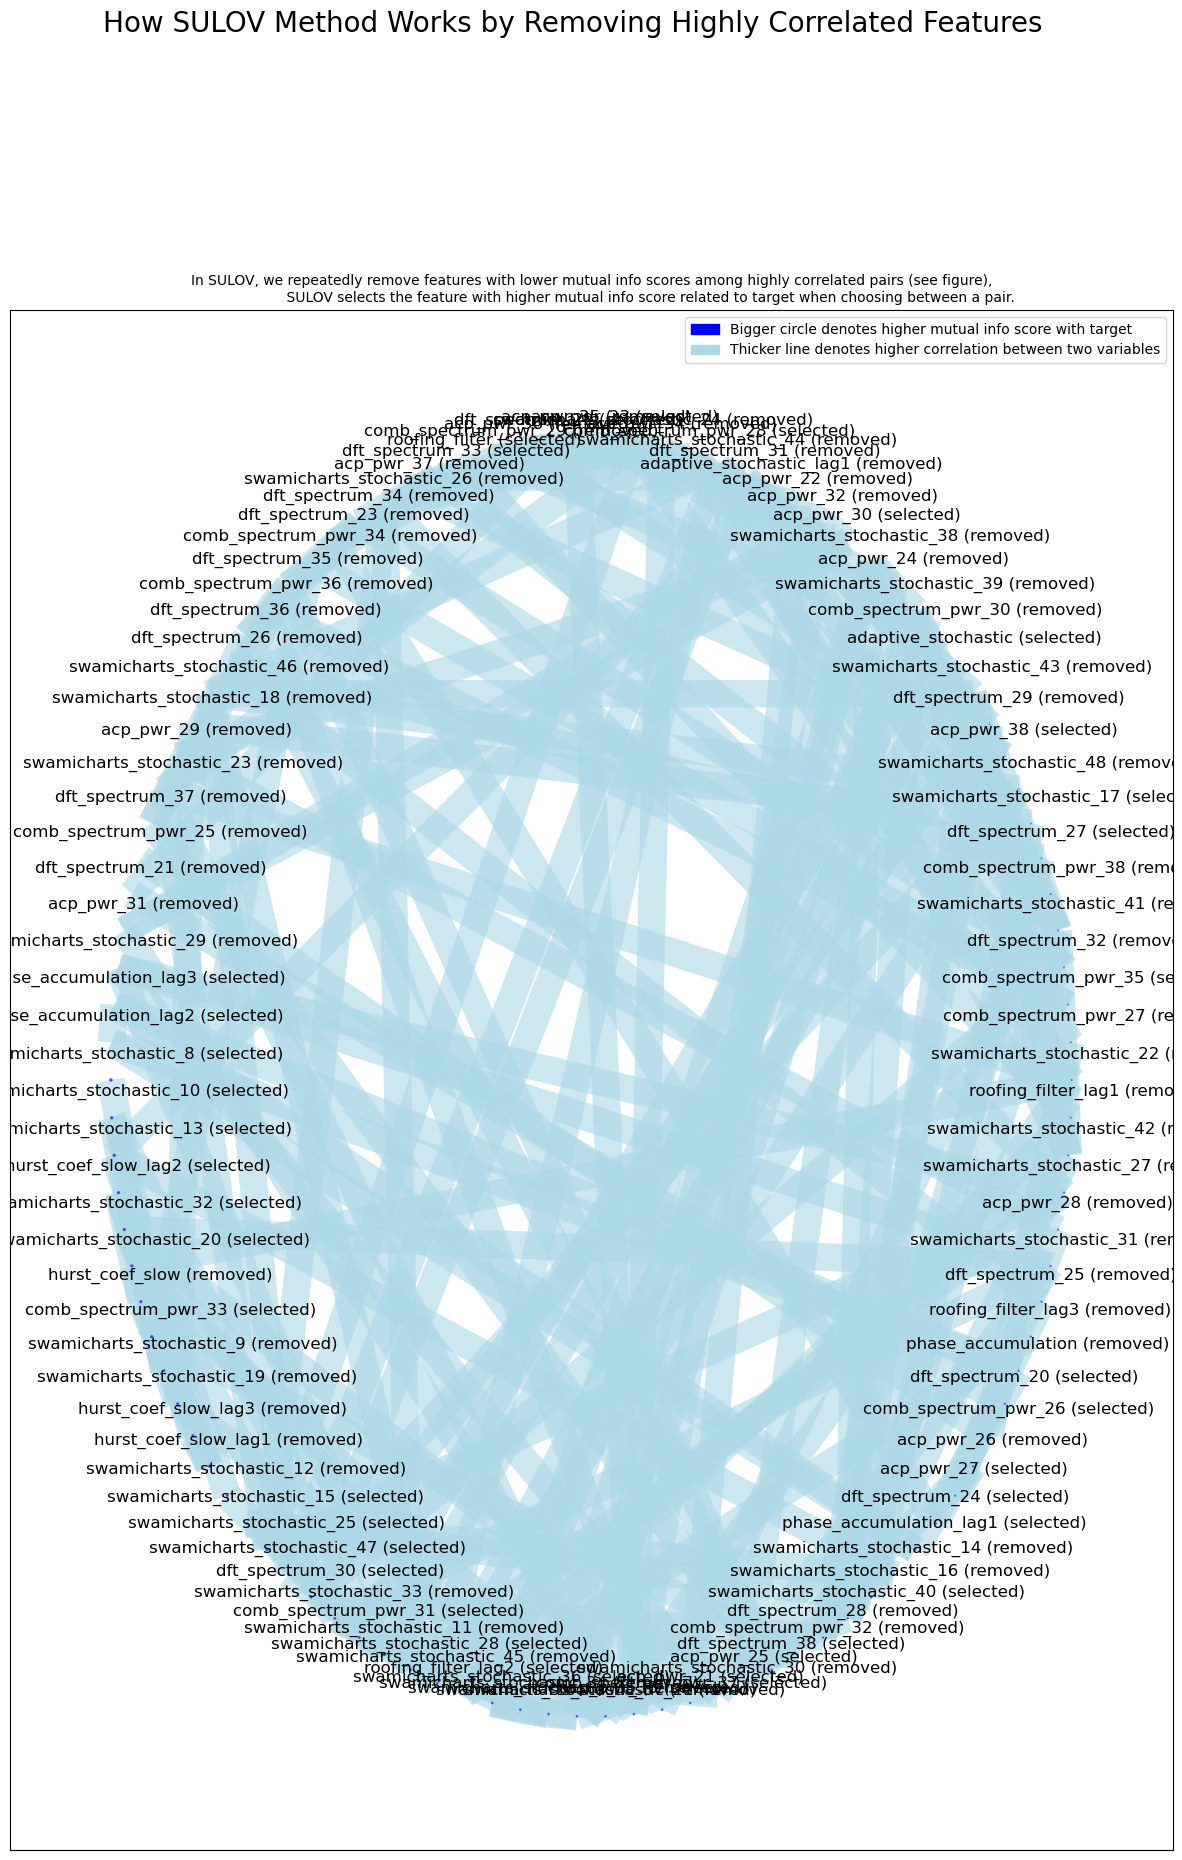

Performing recursive XGBoost feature selection from 359 features...
    Taking top 71 features per iteration...
    Number of booster rounds = 20
    time taken to run entire featurewiz = 748 second(s)
Recursive XGBoost selected 188 features...
#### Starting featurewiz transform for test data ####
Loaded input data. Shape = (604082, 426)
#### Starting lazytransform for test data ####
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (604082, 426)
Returning dataframe with 188 features 


['evenbetter_sinewave_long',
 'evenbetter_sinewave_short',
 'bandpass_dt',
 'evenbetter_sinewave_long_lag3',
 'roofing_filter_ddt',
 'bandpass_ddt',
 'phase_accumulation_lag1',
 'ac_1',
 'ac_35',
 'roofing_filter_lag2',
 'hurst_coef_slow_lag2',
 'phase_accumulation_dt',
 'roofing_filter_dt',
 'roofing_filter',
 'highpass_bp_dt',
 'phase_accumulation_lag3',
 'acp_pwr_38',
 'comb_spectrum_pwr_24',
 'hurst_coef_slow_dt',
 'comb_spectrum_pwr_37',
 'hurst_coef_fast',
 'comb_spectrum_pwr_33',
 'acp_pwr_5',
 'comb_spectrum_pwr_10',
 'ac_39',
 'phase_accumulation_ddt',
 'hurst_coef_fast_lag3',
 'phase_accumulation_lag2',
 'acp_pwr_23',
 'comb_spectrum_pwr_11',
 'comb_spectrum_pwr_14',
 'comb_spectrum_pwr_23',
 'acp_pwr_9',
 'acp_pwr_0',
 'ac_15',
 'comb_spectrum_pwr_19',
 'evenbetter_sinewave_long_lag2',
 'homodyne_lag2',
 'evenbetter_sinewave_long_lag1',
 'comb_spectrum_pwr_4',
 'acp_pwr_7',
 'ac_24',
 'acp_pwr_10',
 'ac_23',
 'comb_spectrum_pwr_31',
 'acp_pwr_14',
 'dft_spectrum_7',
 'ac_46'

In [4]:
from featurewiz import FeatureWiz

fwiz = FeatureWiz(corr_limit=0.99, verbose=1)
X_train_selected, y_train = fwiz.fit_transform(x_train, y_train)
X_test_selected = fwiz.transform(x_test)
fwiz.features

In [7]:
sorted(fwiz.features)

['ac_1',
 'ac_12',
 'ac_15',
 'ac_22',
 'ac_23',
 'ac_24',
 'ac_28',
 'ac_30',
 'ac_33',
 'ac_35',
 'ac_36',
 'ac_38',
 'ac_39',
 'ac_40',
 'ac_43',
 'ac_45',
 'ac_46',
 'acp_pwr_0',
 'acp_pwr_1',
 'acp_pwr_10',
 'acp_pwr_12',
 'acp_pwr_13',
 'acp_pwr_14',
 'acp_pwr_2',
 'acp_pwr_21',
 'acp_pwr_23',
 'acp_pwr_25',
 'acp_pwr_27',
 'acp_pwr_30',
 'acp_pwr_33',
 'acp_pwr_38',
 'acp_pwr_4',
 'acp_pwr_5',
 'acp_pwr_6',
 'acp_pwr_7',
 'acp_pwr_8',
 'acp_pwr_9',
 'adaptive_bp',
 'adaptive_bp_dt',
 'adaptive_bp_lead',
 'adaptive_cci',
 'adaptive_cci_ddt',
 'adaptive_cci_dt',
 'adaptive_cci_lag2',
 'adaptive_cci_lag3',
 'adaptive_stochastic',
 'adaptive_stochastic_ddt',
 'adaptive_stochastic_dt',
 'adaptive_stochastic_lag2',
 'adaptive_stochastic_lag3',
 'bandpass_ddt',
 'bandpass_dt',
 'comb_spectrum_dom_cycle_dt',
 'comb_spectrum_dom_cycle_lag3',
 'comb_spectrum_pwr_0',
 'comb_spectrum_pwr_1',
 'comb_spectrum_pwr_10',
 'comb_spectrum_pwr_11',
 'comb_spectrum_pwr_12',
 'comb_spectrum_pwr_13',


In [8]:
import json

with open("research/fwiz.json", "w") as f:
    json.dump(sorted(fwiz.features), f)